# Support Vector Machine

In [2]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# to enable local imports
module_path = os.path.abspath('../code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning_data_generation import loadOnlineEEGdata

D:\Masterthesis\thesis_eeg\code


Using TensorFlow backend.


### K Fold Validierung - Owm implementation
You don't have to use this because sklearn offers the same as a function already `sklearn.model_selection.cross_val_score`

In [3]:
# load the data
# load the dataset
#eegData, freqData = loadOnlineEEGdata(splitData=False)
#eegX, eegy = eegData
#freqX, freqy = freqData

def testSvmFold(X, y, fold = 10, shuffle=True):
    
    scores = []
    kfold = KFold(fold, shuffle=shuffle)
    for train_index, test_index in kfold.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        # define train/test X/y
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # define model
        C = 1.0  # SVM regularization parameter
        #odels = svm.SVC(kernel='linear', C=C)
        #odel = svm.LinearSVC(C=C, max_iter=10000)
        model = svm.SVC(kernel='rbf', gamma=0.7, C=C)
        #model = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)

        # fit model on train set
        model.fit(X_train, y_train)

        # forecast test set
        yhat = model.predict(X_test)

        # evaluate predictions
        score = accuracy_score(y_test, yhat)
        # store

        scores.append(score)
        print('>%.3f' % score)
        
    # calculate mean score across each run
    print('Final Score: %.3f' % (np.mean(scores)))
    
# Test with Frequency Data
#testSvmFold(X=freqX.reshape(1440,1200), y=freqy, fold=10, shuffle=True)

# Test with EEG Data
#testSvmFold(X=eegX[:, :, 6], y=eegy, fold=2, shuffle=True)

In [4]:
# Load some online EEG Data
eegData, freqData, entropyData = loadOnlineEEGdata(splitData=True)
eegX_train, eegy_train, eegX_test, eegy_test = eegData
freqX_train, freqy_train, freqX_test, freqy_test = freqData
X_train_entropy, y_train_entropy, X_test_entropy, y_test_entropy = entropyData

# reshape
freqX_train = freqX_train.reshape(freqX_train.shape[0], freqX_train.shape[2])
freqX_test = freqX_test.reshape(freqX_test.shape[0], freqX_test.shape[2])

X_train_entropy = X_train_entropy.reshape(X_train_entropy.shape[0], X_train_entropy.shape[2])
X_test_entropy = X_test_entropy.reshape(X_test_entropy.shape[0], X_test_entropy.shape[2])


Loading Online EEG Data from D:/Masterthesis/EEG_Data/eeg_data_online ...
EEG Data Shape:
(5024, 512, 40) (5024,) (2154, 512, 40) (2154,)
Freq Data Shape:
(1008, 1, 1200) (1008,) (432, 1, 1200) (432,)
Entropy Data Shape:
(5024, 1, 200) (5024,) (2154, 1, 200) (2154,)


# Create & Evaluate Model
- Here we create a very simpel Support Vector Machine Model
- Then we use `cross_val_score` to get some Accuracies (uses kfold)
- Then we use `cross_val_predict` to get some predictions (uses kfold)
- With the predictions we can measure how good the model is
    - We create a confusions matrix
    - We calculate the Precision
    - We calculate the F1 Score

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score) 

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)   

def plot_precision_vs_recall(precisions, recalls):
    plt.title("Precision versus recall")
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.title("Precision versus recall - Threshold Plot")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)      


# Create a model
def evaluateModel(model,X_train, y_train, X_test=None, y_test=None, kfoldTimes=8):
    
    print("Model: {}".format(model))
    
    # generate cross val score
    kfoldTimes = kfoldTimes
    print("Calculating cross val scores...")
    accuaries = cross_val_score(model, X_train, y_train, cv=kfoldTimes, scoring=f1_scorer)
    print("Cross val scores (Accuracies):")
    for i in range(0, len(accuaries)):
        print(" Fold {fold}: {acc}".format(fold=i+1, acc=accuaries[i]))

    # make predictions with the model
    print("\nCaclulating cross val predictions...")
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=kfoldTimes)


    svm_confusionMatrix = confusion_matrix(y_train, y_train_pred)
    print("""\nConfusion Matrix\n------------------------
    True Negative:   {tn} - False Positive: {fp}
    False Negatives: {fn} - True positive:  {tp}""".format(tn=svm_confusionMatrix[0][0],
                                                           fp=svm_confusionMatrix[0][1],
                                                           fn=svm_confusionMatrix[1][0],
                                                           tp=svm_confusionMatrix[1][1]))

    print("----------------------")
    print("Precision: {} ".format(precision_score(y_train, y_train_pred)))
    print("Recall:    {}".format(recall_score(y_train, y_train_pred)))
    print("F1 Score:  {}".format(f1_score(y_train, y_train_pred)))
    
    # Calculate and plot the precion-recall tradeoff
    model.fit(X_train, y_train)
    y_score = model.decision_function(X_train)
    average_precision = average_precision_score(y_train, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    disp = plot_precision_recall_curve(model, X_train, y_train)
    disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    
    # Calculate and plot precision vs. recall - threshold plot
    y_scores_dec_func = cross_val_predict(model, X_train, y_train, cv=kfoldTimes, method="decision_function")
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_dec_func)
    
    plt.figure(figsize=(8, 4))
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    
    # Plot precision vs. recall directly against each other
    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    
    
    # Calculate and plot the ROC Curve
    fpr, tpr, thresholds = roc_curve(y_train, y_scores_dec_func)
    plt.figure(figsize=(8, 6)) 
    plot_roc_curve(fpr, tpr)
    
    
    # Compare to another model
    from sklearn.ensemble import RandomForestClassifier
    forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=kfoldTimes,
                                        method="predict_proba")
    
    y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
    fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, "b:", linewidth=2, label="SVM")
    plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
    plt.grid(True)
    plt.legend(loc="lower right", fontsize=16)


Model: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Average precision-recall score: 1.00


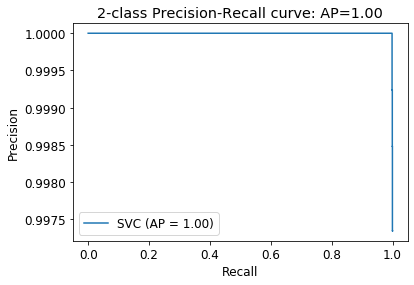

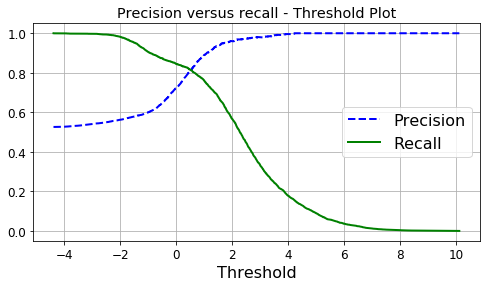

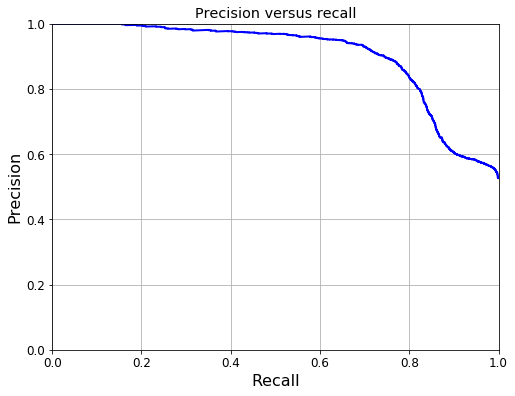

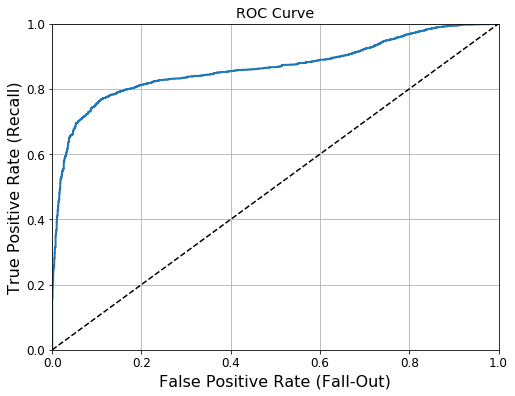

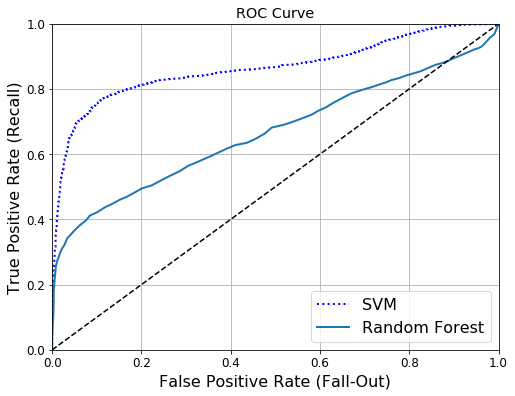

In [38]:
# good model
goodModel = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

simpleModel = svm.SVC(kernel='rbf', gamma=0.3, C=1.0)


evaluateModel(model=goodModel,
              X_train=X_train_entropy,
              y_train=y_train_entropy,
              X_test=X_test_entropy,
              y_test=y_test_entropy)

# Find best parameters for the SVM
Now we try to find the best parameters for the Support Vector Machine

In [11]:
from sklearn.model_selection import GridSearchCV


# Create a model to test
svm_model = svm.SVC()

# Create a parameter grid - here you specifiy which combinations you want to test
param_grid = [
    {'kernel': ['poly', 'rbf', 'sigmoid'],
     'degree': [2, 3, 5, 10], # only for poly kernel
     'gamma': ['scale', 'auto']
    } 
    
    #{'kernel': ['rbf','poly'], 'degree': [2, 3, 5, 10], 'C': [0.5, 1, 5], 'coef0' : [1, 10, 100], 'gamme' :['scale', 'auto']}
    #{'kernel': ['rbf'], 'gamma': ['scale', 'auto'], 'C': [0.2, 0.5, 0.75, 1, 5], 'degree': [2, 3, 5, 10]},
    #{'kernel': ['poly'], 'degree': [2, 3, 5, 10], 'C': [0.5, 1, 5], 'coef0' : [1, 10, 100], 'gamma': ['scale', 'auto']},
    #{'kernel': ['rbf'], 'gamma': ['scale'], 'C': [1,2]},
    #{'kernel': ['poly'], 'degree': [3, 5], 'C': [0.5, 1], 'coef0' : [1], 'gamma': ['scale']},
]

kFoldTimes = 8

# create a grid search
grid_search = GridSearchCV(svm_model, param_grid, cv=kFoldTimes,
                            scoring='accuracy',
                            return_train_score=True)

# fit it with the data
result = grid_search.fit(X_train_entropy, y_train_entropy)

In [18]:
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.20.3


In [12]:
grid_search.best_params_

{'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}

In [13]:
grid_search.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.6725716560509554 {'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
0.6263933121019108 {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
0.4267515923566879 {'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.5406050955414012 {'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
0.5252786624203821 {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
0.5314490445859873 {'degree': 2, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.7289012738853503 {'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
0.6263933121019108 {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
0.4267515923566879 {'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.5527468152866242 {'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
0.5252786624203821 {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
0.5314490445859873 {'degree': 3, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.7406449044585988 {'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}
0.6263933121019108 {'degree': 5, 'gamma': 'scale', 'kernel': 'rbf'}
0.4267515923566879 {'degree': 5, 

In [ ]:
evaluateModel(grid_search.best_estimator_, X_train_entropy, y_train_entropy)

Model: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Calculating cross val scores...
Cross val scores (Accuracies):
 Fold 1: 0.1698630136986301
 Fold 2: 0.7597633136094675
 Fold 3: 0.7315357561547479
 Fold 4: 0.835781041388518
 Fold 5: 0.7915632754342432
 Fold 6: 0.9078014184397163
 Fold 7: 0.8354792560801145
 Fold 8: 0.8665749656121046

Caclulating cross val predictions...
